# TTC Subway Delay Data Prep

## Download Data

In [ ]:
import os
import re
import json
import numpy as np
import pandas as pd

import openpyxl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#concat data from all years
dm_data_2018 = pd.read_excel('/content/drive/MyDrive/subway_eda/ttc-subway-delay-data-2018.xlsx', sheet_name=None)
dm_data_concat_2018 = pd.concat(dm_data_2018.values())
dm_data_2019 = pd.read_excel('/content/drive/MyDrive/subway_eda/ttc-subway-delay-data-2019.xlsx', sheet_name=None)
dm_data_concat_2019 = pd.concat(dm_data_2019.values())
dm_data_2020 = pd.read_excel('/content/drive/MyDrive/subway_eda/ttc-subway-delay-data-2020.xlsx', sheet_name=None)
dm_data_concat_2020 = pd.concat(dm_data_2020.values())
dm_data_2021 = pd.read_excel('/content/drive/MyDrive/subway_eda/ttc-subway-delay-data-2021.xlsx', sheet_name=None)
dm_data_concat_2021 = pd.concat(dm_data_2021.values())
dm_data_2022 = pd.read_excel('/content/drive/MyDrive/subway_eda/ttc-subway-delay-data-2022.xlsx', sheet_name=None)
dm_data_concat_2022 = pd.concat(dm_data_2022.values())
frames = [dm_data_concat_2022,dm_data_concat_2021,dm_data_concat_2020,dm_data_concat_2019,dm_data_concat_2018]
concat_frame = pd.concat(frames)
concat_frame.reset_index(drop=True) 

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2022-01-01,15:59,Saturday,LAWRENCE EAST STATION,SRDP,0,0,N,SRT,3023
1,2022-01-01,02:23,Saturday,SPADINA BD STATION,MUIS,0,0,NaN,BD,0
2,2022-01-01,22:00,Saturday,KENNEDY SRT STATION TO,MRO,0,0,NaN,SRT,0
3,2022-01-01,02:28,Saturday,VAUGHAN MC STATION,MUIS,0,0,NaN,YU,0
4,2022-01-01,02:34,Saturday,EGLINTON STATION,MUATC,0,0,S,YU,5981
...,...,...,...,...,...,...,...,...,...,...
79520,2018-12-31,22:34,Monday,DUNDAS STATION,PUMST,0,0,NaN,YU,0
79521,2018-12-31,22:36,Monday,DUNDAS STATION,SUDP,3,6,N,YU,5881
79522,2018-12-31,23:08,Monday,BLOOR STATION,MUIRS,0,0,NaN,YU,0
79523,2018-12-31,23:21,Monday,QUEEN'S PARK STATION,TUSC,0,0,S,YU,5841


##Delay Code to Delay description

In [ ]:
mapping = pd.read_excel('/content/drive/MyDrive/subway_eda/ttc-subway-delay-codes.xlsx',sheet_name = None)
mapping_all = pd.concat(mapping.values())

In [ ]:
#desc for code


#renaming columns
mapping_all = mapping_all.drop(columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 4', 'Unnamed: 5'], index = 0)
mapping_all.columns = ['code_sub', 'desc_sub', 'code_srt', 'desc_srt']

mapping_all = pd.concat([
    mapping_all[['code_sub', 'desc_sub']].rename(columns = {'code_sub': 'Code', 'desc_sub': 'Desc'}), 
    mapping_all[['code_srt', 'desc_srt']].rename(columns = {'code_srt': 'Code', 'desc_srt': 'Desc'})
])

mapping_all.Code = mapping_all.Code.str.strip()
mapping_all = mapping_all.dropna().reset_index(drop = True)

mapping_all.head()

,Code,Desc
0,EUAC,Air Conditioning
1,EUAL,Alternating Current
2,EUATC,ATC RC&S Equipment
3,EUBK,Brakes
4,EUBO,Body


In [ ]:
df_merged = concat_frame.merge(
    mapping_all, 
    on = 'Code', 
    how = 'left'
)

print(df_merged.shape)
print(df_merged.head())

(79525, 11)
        Date   Time       Day                 Station   Code  Min Delay  \
0 2022-01-01  15:59  Saturday   LAWRENCE EAST STATION   SRDP          0   
1 2022-01-01  02:23  Saturday      SPADINA BD STATION   MUIS          0   
2 2022-01-01  22:00  Saturday  KENNEDY SRT STATION TO    MRO          0   
3 2022-01-01  02:28  Saturday      VAUGHAN MC STATION   MUIS          0   
4 2022-01-01  02:34  Saturday        EGLINTON STATION  MUATC          0   

   Min Gap Bound Line  Vehicle  \
0        0     N  SRT     3023   
1        0   NaN   BD        0   
2        0   NaN  SRT        0   
3        0   NaN   YU        0   
4        0     S   YU     5981   

                                                Desc  
0                                  Disorderly Patron  
1  Injured or ill Customer (In Station) - Transpo...  
2                                Miscellaneous Other  
3  Injured or ill Customer (In Station) - Transpo...  
4                                        ATC Project  


In [ ]:
df_merged.isnull().sum()

Date             0
Time             0
Day              0
Station          0
Code             0
Min Delay        0
Min Gap          0
Bound        19233
Line           269
Vehicle          0
Desc          1526
dtype: int64

In [ ]:
df_merged.groupby('Line').apply(
    lambda x: pd.Series({
        'pct_missing_bound': x['Bound'].isnull().mean(),
        'n_obs': x.shape[0]})
).sort_values(by = 'n_obs', ascending = False)[:10]

,pct_missing_bound,n_obs
Line,,
YU,0.206263,40429.0
BD,0.236082,31146.0
SRT,0.320521,3226.0
SHP,0.222182,2750.0
YU/BD,0.994795,1537.0
YU / BD,1.000000,66.0
YUS,0.518519,27.0
YU/ BD,1.000000,14.0
999,1.000000,8.0


##Delay Reason Descriptions

In [ ]:
df_merged[df_merged.Desc.isnull()].Code.value_counts()[:10]

MUNCA    1311
PUEO       85
TRNCA      66
TUNCA      23
PUEWZ      17
MUPF        8
XXXXX       4
PUEME       3
MFO         2
SUPD        1
Name: Code, dtype: int64

In [ ]:
df_merged = df_merged.fillna('')

##Line info

In [ ]:
df_merged.Line.value_counts()[:30]

YU                        40429
BD                        31146
SRT                        3226
SHP                        2750
YU/BD                      1537
                            269
YU / BD                      66
YUS                          27
YU/ BD                       14
999                           8
BD/YU                         6
YU-BD                         4
YU & BD                       3
B/D                           2
16 MCCOWAN                    2
SHEP                          2
35 JANE                       2
YUS/BD                        2
YU - BD                       2
YU\BD                         1
46 MARTIN GROVE               1
RT                            1
BLOOR-DANFORTH                1
134 PROGRESS                  1
BLOOR DANFORTH LINES          1
985 SHEPPARD EAST EXPR        1
22 COXWELL                    1
100 FLEMINGDON PARK           1
YU LINE                       1
YONGE UNIVERSITY SERVI        1
Name: Line, dtype: int64

In [ ]:
df_merged['line_cleaned'] = df_merged.Line

df_merged = df_merged[~df_merged.line_cleaned.str.contains('^[0-9]')]
print(df_merged.shape)

(79499, 12)


In [ ]:
df_merged

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Desc,line_cleaned
0,2022-01-01,15:59,Saturday,LAWRENCE EAST STATION,SRDP,0,0,N,SRT,3023,Disorderly Patron,SRT
1,2022-01-01,02:23,Saturday,SPADINA BD STATION,MUIS,0,0,,BD,0,Injured or ill Customer (In Station) - Transpo...,BD
2,2022-01-01,22:00,Saturday,KENNEDY SRT STATION TO,MRO,0,0,,SRT,0,Miscellaneous Other,SRT
3,2022-01-01,02:28,Saturday,VAUGHAN MC STATION,MUIS,0,0,,YU,0,Injured or ill Customer (In Station) - Transpo...,YU
4,2022-01-01,02:34,Saturday,EGLINTON STATION,MUATC,0,0,S,YU,5981,ATC Project,YU
...,...,...,...,...,...,...,...,...,...,...,...,...
79520,2018-12-31,22:34,Monday,DUNDAS STATION,PUMST,0,0,,YU,0,Station Stairway Incident,YU
79521,2018-12-31,22:36,Monday,DUNDAS STATION,SUDP,3,6,N,YU,5881,Disorderly Patron,YU
79522,2018-12-31,23:08,Monday,BLOOR STATION,MUIRS,0,0,,YU,0,Injured or ill Customer (In Station) - Medical...,YU
79523,2018-12-31,23:21,Monday,QUEEN'S PARK STATION,TUSC,0,0,S,YU,5841,Operator Overspeeding,YU


 ## values are mapped to a consistent naming convention
 with station at both lines add line1_line2 ex YU_BD

In [ ]:
import json
with open("/content/drive/MyDrive/subway_eda/line_spelling_mapping.json", "r") as f:
    line_spelling_mapping = json.load(f)

In [ ]:
df_merged.line_cleaned = list(map(
    lambda x: line_spelling_mapping.get(x, x), 
    df_merged.line_cleaned
))

df_merged.line_cleaned.unique()

array(['SRT', 'BD', 'YU', 'YU_BD', 'SHP', ''], dtype=object)

In [ ]:
df_merged

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Desc,line_cleaned
0,2022-01-01,15:59,Saturday,LAWRENCE EAST STATION,SRDP,0,0,N,SRT,3023,Disorderly Patron,SRT
1,2022-01-01,02:23,Saturday,SPADINA BD STATION,MUIS,0,0,,BD,0,Injured or ill Customer (In Station) - Transpo...,BD
2,2022-01-01,22:00,Saturday,KENNEDY SRT STATION TO,MRO,0,0,,SRT,0,Miscellaneous Other,SRT
3,2022-01-01,02:28,Saturday,VAUGHAN MC STATION,MUIS,0,0,,YU,0,Injured or ill Customer (In Station) - Transpo...,YU
4,2022-01-01,02:34,Saturday,EGLINTON STATION,MUATC,0,0,S,YU,5981,ATC Project,YU
...,...,...,...,...,...,...,...,...,...,...,...,...
79520,2018-12-31,22:34,Monday,DUNDAS STATION,PUMST,0,0,,YU,0,Station Stairway Incident,YU
79521,2018-12-31,22:36,Monday,DUNDAS STATION,SUDP,3,6,N,YU,5881,Disorderly Patron,YU
79522,2018-12-31,23:08,Monday,BLOOR STATION,MUIRS,0,0,,YU,0,Injured or ill Customer (In Station) - Medical...,YU
79523,2018-12-31,23:21,Monday,QUEEN'S PARK STATION,TUSC,0,0,S,YU,5841,Operator Overspeeding,YU


## replacing null in line values using line to station mapping

In [ ]:
import json
with open("/content/drive/MyDrive/subway_eda/line_station_mapping.json", "r") as f:
    line_station_mapping = json.load(f)

In [ ]:
df_merged.line_cleaned = list(map(
    lambda x, y: line_station_mapping.get(y, x) if x == '' else x, 
    df_merged.line_cleaned, 
    df_merged.Station
))

In [ ]:
df_merged[df_merged.line_cleaned == ''].Station.value_counts()[:30]

WILSON CARHOUSE           10
GREENWOOD YARD             9
GREENWOOD CARHOUSE         5
INGLIS BUILDING            5
DANFORTH DIVISION          5
YONGE-UNIVERSITY AND B     4
DAVISVILLE YARD            4
MCBRIEN BUILDING           3
GREENWOOD SHOPS            3
TRANSIT CONTROL            3
TRANSIT CONTROL CENTRE     2
GO PROTOCOL                2
GREENWOOD SHOP             2
DUNCAN SHOP                2
GUNN BUILDING              2
HARVEY SHOP                2
WILSON HOSTLER             2
WILSON YARD                2
LOWER BAY                  1
UNION TO MAIN STREET       1
DON MLLS STATION           1
EGLINTON BUS TERMINAL      1
GO PROTOCOL - BARRIE L     1
KING AND BATHURST          1
DAVISVILLE YARD - TUNN     1
SCARBOROUGH CTR STATIO     1
UNION, MAIN, KENNEDY S     1
SUBWAY OPS BUILDING        1
DUNCAN SHOPS               1
40 CARL HALL ROAD UNIT     1
Name: Station, dtype: int64

In [ ]:
#remove null remaning after merging mapping
df_merged = df_merged[df_merged.line_cleaned != ''].reset_index(drop = True)

print(df_merged.shape)
print(df_merged.head())

(79393, 12)
        Date   Time       Day                 Station   Code  Min Delay  \
0 2022-01-01  15:59  Saturday   LAWRENCE EAST STATION   SRDP          0   
1 2022-01-01  02:23  Saturday      SPADINA BD STATION   MUIS          0   
2 2022-01-01  22:00  Saturday  KENNEDY SRT STATION TO    MRO          0   
3 2022-01-01  02:28  Saturday      VAUGHAN MC STATION   MUIS          0   
4 2022-01-01  02:34  Saturday        EGLINTON STATION  MUATC          0   

   Min Gap Bound Line  Vehicle  \
0        0     N  SRT     3023   
1        0         BD        0   
2        0        SRT        0   
3        0         YU        0   
4        0     S   YU     5981   

                                                Desc line_cleaned  
0                                  Disorderly Patron          SRT  
1  Injured or ill Customer (In Station) - Transpo...           BD  
2                                Miscellaneous Other          SRT  
3  Injured or ill Customer (In Station) - Transpo...        

##Station name cleaning up

In [ ]:
df_merged['Station'].unique()

array(['LAWRENCE EAST STATION', 'SPADINA BD STATION',
       'KENNEDY SRT STATION TO', 'VAUGHAN MC STATION', 'EGLINTON STATION',
       'QUEEN STATION', 'DAVISVILLE STATION', 'ST PATRICK STATION',
       'PAPE STATION', 'WILSON STATION', 'KENNEDY BD STATION',
       'FINCH STATION', 'YONGE BD STATION', 'ST ANDREW STATION',
       'MAIN STREET STATION', 'HIGH PARK STATION', 'GREENWOOD STATION',
       'COXWELL STATION', 'WELLESLEY STATION', 'SHEPPARD WEST STATION',
       'BLOOR STATION', 'UNION STATION', 'ST GEORGE YUS STATION',
       'RUNNYMEDE STATION', 'ROSEDALE STATION', 'ISLINGTON STATION',
       'SHERBOURNE STATION', 'HIGHWAY 407 STATION', 'KIPLING STATION',
       'YONGE/UNIVERSITY AND B', 'ST GEORGE BD STATION',
       'CHRISTIE STATION', 'BESSARION STATION', 'MCCOWAN STATION',
       'ST CLAIR WEST STATION', 'YORKDALE STATION', 'BATHURST STATION',
       'WARDEN STATION', 'COLLEGE STATION', 'DUPONT STATION',
       'KEELE STATION', 'LAWRENCE WEST STATION', 'LANSDOWNE STATION

In [ ]:
#To simplify things, we can first remove punctuation marks from all station names. 
df_merged['station_cleaned'] = [re.sub('\.|\'', '', re.sub(' \(.*$', '', x)) for x in df_merged.Station]

In [ ]:
station_fixed_mapping = pd.read_csv('/content/drive/MyDrive/subway_eda/station_spellings.csv')
station_fixed_mapping.head()


,station_cleaned,station_fixed
0,KIPLING STATION,KIPLING STATION
1,KENNEDY BD STATION,KENNEDY BD STATION
2,YONGE UNIVERSITY LINE,YU
3,FINCH STATION,FINCH STATION
4,SHEPPARD WEST STATION,SHEPPARD WEST STATION


In [ ]:
#merging for spelling checks for station
df_merged = df_merged.merge(
    station_fixed_mapping, 
    on = 'station_cleaned', 
    how = 'left'
)

print(df_merged.shape)

(79393, 14)


In [ ]:
df_merged

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Desc,line_cleaned,station_cleaned,station_fixed
0,2022-01-01,15:59,Saturday,LAWRENCE EAST STATION,SRDP,0,0,N,SRT,3023,Disorderly Patron,SRT,LAWRENCE EAST STATION,LAWRENCE EAST STATION
1,2022-01-01,02:23,Saturday,SPADINA BD STATION,MUIS,0,0,,BD,0,Injured or ill Customer (In Station) - Transpo...,BD,SPADINA BD STATION,SPADINA BD STATION
2,2022-01-01,22:00,Saturday,KENNEDY SRT STATION TO,MRO,0,0,,SRT,0,Miscellaneous Other,SRT,KENNEDY SRT STATION TO,NaN
3,2022-01-01,02:28,Saturday,VAUGHAN MC STATION,MUIS,0,0,,YU,0,Injured or ill Customer (In Station) - Transpo...,YU,VAUGHAN MC STATION,VAUGHAN MC STATION
4,2022-01-01,02:34,Saturday,EGLINTON STATION,MUATC,0,0,S,YU,5981,ATC Project,YU,EGLINTON STATION,EGLINTON STATION
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79388,2018-12-31,22:34,Monday,DUNDAS STATION,PUMST,0,0,,YU,0,Station Stairway Incident,YU,DUNDAS STATION,DUNDAS STATION
79389,2018-12-31,22:36,Monday,DUNDAS STATION,SUDP,3,6,N,YU,5881,Disorderly Patron,YU,DUNDAS STATION,DUNDAS STATION
79390,2018-12-31,23:08,Monday,BLOOR STATION,MUIRS,0,0,,YU,0,Injured or ill Customer (In Station) - Medical...,YU,BLOOR STATION,BLOOR STATION
79391,2018-12-31,23:21,Monday,QUEEN'S PARK STATION,TUSC,0,0,S,YU,5841,Operator Overspeeding,YU,QUEENS PARK STATION,QUEENS PARK STATION


In [ ]:
#will remove the enteries with shops and carhouse since they are likely not train delays
df_merged[df_merged.station_fixed.isnull()].station_cleaned.value_counts()[:30]

TORONTO TRANSIT COMMIS    264
GREENWOOD YARD            171
WILSON YARD               142
KENNEDY SRT STATION TO     96
DAVISVILLE YARD            66
WILSON HOSTLER             61
WILSON CARHOUSE            42
YONGE SHEP STATION         40
MCCOWAN YARD               39
KEELE YARD                 26
GREENWOOD WYE              26
GREENWOOD CARHOUSE         24
DAVISVILLE BUILD UP        21
GREENWOOD PORTAL           20
KENNEDY SRT TO LAWREN      19
LAWRENCE EAST TO KENNE     18
DAVISVILLE CARHOUSE        16
YONGE/UNIVERSITY AND B     16
EGLINTON                   16
ST GEORGE YU STATION       14
DAVISVILLE HOSTLER         13
BLOOR-DANFORTH LINE        11
TRANSIT CONTROL CENTRE     11
LAWRENCE TO ST CLAIR S     10
SHEPPARD WEST MIGRATIO     10
DANFORTH DIVISION          10
MCCOWAN CARHOUSE            9
GREENWOOD SHOP              8
YONGE UNIVERSITY SPADI      8
DAVISVILLE BUILD-UP         8
Name: station_cleaned, dtype: int64

In [ ]:
df_merged = (df_merged[~df_merged.station_fixed.isnull()].reset_index(drop = True)
                                    .drop(columns = ['station_cleaned'])
                                    .rename(columns = {'station_fixed': 'station_cleaned'}))

print(df_merged.shape)
print(df_merged.head())

(77510, 13)
        Date   Time       Day                Station   Code  Min Delay  \
0 2022-01-01  15:59  Saturday  LAWRENCE EAST STATION   SRDP          0   
1 2022-01-01  02:23  Saturday     SPADINA BD STATION   MUIS          0   
2 2022-01-01  02:28  Saturday     VAUGHAN MC STATION   MUIS          0   
3 2022-01-01  02:34  Saturday       EGLINTON STATION  MUATC          0   
4 2022-01-01  05:40  Saturday          QUEEN STATION  MUNCA          0   

   Min Gap Bound Line  Vehicle  \
0        0     N  SRT     3023   
1        0         BD        0   
2        0         YU        0   
3        0     S   YU     5981   
4        0         YU        0   

                                                Desc line_cleaned  \
0                                  Disorderly Patron          SRT   
1  Injured or ill Customer (In Station) - Transpo...           BD   
2  Injured or ill Customer (In Station) - Transpo...           YU   
3                                        ATC Project          

## Delay Duration

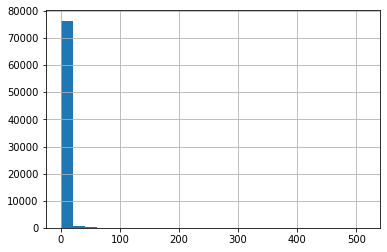

In [ ]:
df_merged['Min Delay'].hist(bins = 25)

In [ ]:
df_merged[df_merged['Min Delay'] > 200]

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Desc,line_cleaned,station_cleaned
1421,2022-01-25,21:03,Tuesday,SCARBOROUGH CTR STATIO,PRSL,285,291,S,SRT,3010,Loop Related Failures,SRT,SCARB CTR STATION
1476,2022-01-26,20:15,Wednesday,KENNEDY SRT STATION,MRWEA,315,321,S,SRT,3020,Weather Reports / Related Delays,SRT,KENNEDY SRT STATION
2312,2022-02-09,06:06,Wednesday,DUPONT STATION,SUAE,240,243,S,YU,5426,Assault / Employee Involved,YU,DUPONT STATION
3022,2022-02-22,06:12,Tuesday,KENNEDY SRT STATION,MRPLB,221,226,S,SRT,3014,Fire/Smoke Plan B,SRT,KENNEDY SRT STATION
4035,2022-03-12,12:59,Saturday,ELLESMERE STATION,PRSL,206,212,N,SRT,3019,Loop Related Failures,SRT,ELLESMERE STATION
4594,2022-03-23,09:22,Wednesday,SHEPPARD-YONGE STATION,PUSRA,220,225,E,SHP,6166,Subway Radio System Fault,SHP,SHEPPARD-YONGE STATION
6406,2022-04-28,06:02,Thursday,JANE STATION,PUTR,388,394,E,BD,5225,Rail Related Problem,BD,JANE STATION
8321,2021-01-05,13:02,Tuesday,ISLINGTON STATION,MUPR1,207,210,E,BD,5260,Priority One - Train in Contact With Person,BD,ISLINGTON STATION
12800,2021-04-30,06:15,Friday,SHEPPARD WEST STATION,PUTWZ,255,259,N,YU,0,Work Zone Problems - Track,YU,SHEPPARD WEST STATION
13651,2021-05-24,05:48,Monday,MCCOWAN STATION,PRSL,275,0,S,SRT,3014,Loop Related Failures,SRT,MCCOWAN STATION


In [ ]:
df_merged = df_merged[df_merged['Min Delay'] < 999]

print(df_merged.shape)

(77510, 13)


In [ ]:
(df_merged['Min Delay'] == 0).mean()

0.5899496839117533

In [ ]:
df_merged['Min Delay'] = df_merged['Min Delay'].replace(0, 0.5)

assert (df_merged['Min Delay'] == 0).sum() == 0

In [ ]:
with open('/content/drive/MyDrive/subway_eda/stations_ordered.json') as json_file:
    stations_ordered = json.load(json_file)
    
num_stations = {
    'YU': 38, 
    'BD': 31, 
    'YU_BD': 69,
    'SRT': 6,
    'SHP': 5,
    'YU_BD_SHP': 74,
    'ALL': 80  
}

all_stations = sum(stations_ordered.values(), [])

In [ ]:
stations_ordered.keys()

dict_keys(['YU', 'BD', 'SRT', 'SHP'])

In [ ]:
df_mult_station = df_merged[(df_merged.station_cleaned.str.contains(',')) | 
                     (df_merged.station_cleaned.str.contains('_')) |
                     (df_merged.station_cleaned.isin(['YU', 'BD', 'SHP', 'SRT', 'ALL']))].copy()

new_df = pd.DataFrame()

for index, row in df_mult_station.iterrows():
    
    st = row['station_cleaned']
    
    if st in ['YU', 'BD', 'SRT', 'SHP']:
        df_i = pd.concat([row.to_frame(0).T] * num_stations[st])
        df_i.station_cleaned = stations_ordered[st]
    
    elif '_' in st:
        df_i = pd.concat([row.to_frame(0).T] * num_stations[st])       
        df_i.station_cleaned = sum([stations_ordered[st_i] for st_i in st.split('_')], [])
        
    elif st == 'ALL':
        df_i = pd.concat([row.to_frame(0).T] * num_stations[st])       
        df_i.station_cleaned = sum([stations_ordered[k] for k in stations_ordered], [])
    
    else:
        
        fr_stn, to_stn = st.split(', ')
        fr_idx_temp = stations_ordered[row['line_cleaned']].index(fr_stn)
        to_idx_temp = stations_ordered[row['line_cleaned']].index(to_stn)
        fr_idx, to_idx = min(fr_idx_temp, to_idx_temp), max(fr_idx_temp, to_idx_temp)
        
        stations = stations_ordered[row['line_cleaned']][fr_idx:(to_idx + 1)]
        df_i = pd.concat([row.to_frame(0).T] * len(stations))
        df_i.station_cleaned = stations
    
    df_i['Min Delay'] /= df_i.shape[0]
    df_i['indicator_ns'] = [1] + [0] * (df_i.shape[0] - 1)
    df_i['indicator_station'] = [1] * df_i.shape[0]
    
    new_df = new_df.append(df_i)

print(new_df.shape)

(164449, 15)


In [ ]:
df_merged[(~df_merged.station_cleaned.isin(all_stations)) &
   (~df_merged.station_cleaned.str.contains(',')) & 
   (~df_merged.station_cleaned.str.contains('_')) & 
   (~df_merged.station_cleaned.isin(['YU', 'BD', 'SHP', 'SRT', 'ALL']))]


,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Desc,line_cleaned,station_cleaned
165,2022-01-03,23:42,Monday,SHEPPARD-YONGE STATION,TUSC,0.5,0,E,SHP,6196,Operator Overspeeding,SHP,SHEPPARD-YONGE STATION
224,2022-01-04,10:19,Tuesday,SHEPPARD-YONGE STATION,MUSC,0.5,0,E,SHP,6181,Miscellaneous Speed Control,SHP,SHEPPARD-YONGE STATION
225,2022-01-04,22:20,Tuesday,SHEPPARD-YONGE STATION,TUMVS,3.0,8,W,SHP,6186,Operator Violated Signal,SHP,SHEPPARD-YONGE STATION
288,2022-01-05,12:49,Wednesday,SHEPPARD-YONGE STATION,SUDP,3.0,8,E,SHP,6146,Disorderly Patron,SHP,SHEPPARD-YONGE STATION
516,2022-01-09,08:16,Sunday,SHEPPARD-YONGE STATION,TUMVS,0.5,0,E,SHP,6176,Operator Violated Signal,SHP,SHEPPARD-YONGE STATION
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69212,2018-08-06,16:50,Monday,SPADINA STATION,MUIRS,0.5,0,,BD,0,Injured or ill Customer (In Station) - Medical...,BD,SPADINA STATION
69704,2018-08-14,15:53,Tuesday,SPADINA STATION,MUIS,0.5,0,E,BD,0,Injured or ill Customer (In Station) - Transpo...,BD,SPADINA STATION
70023,2018-08-19,22:02,Sunday,SPADINA STATION,EUBK,5.0,10,S,YU,5616,Brakes,YU,SPADINA STATION
70069,2018-08-20,18:05,Monday,SPADINA STATION,MUIS,10.0,13,E,BD,5335,Injured or ill Customer (In Station) - Transpo...,BD,SPADINA STATION


In [ ]:
df_mult_line = df_merged[(~df_merged.station_cleaned.isin(all_stations)) &
                  (~df_merged.station_cleaned.str.contains(',')) & 
                  (~df_merged.station_cleaned.str.contains('_')) & 
                  (~df_merged.station_cleaned.isin(['YU', 'BD', 'SHP', 'SRT', 'ALL']))].copy()

for index, row in df_mult_line.iterrows():
    
    stations = ['SPADINA YU STATION', 'SPADINA BD STATION']
    df_i = pd.concat([row.to_frame(0).T] * len(stations))
    df_i.station_cleaned = stations
    
    df_i['Min Delay'] /= df_i.shape[0]
    df_i['indicator_ns'] = [1] + [0] * (df_i.shape[0] - 1)
    df_i['indicator_station'] = [1] * df_i.shape[0]
    
    new_df = new_df.append(df_i)

print(new_df.shape)

(240667, 30)


In [ ]:
df_no_mult = df_merged[df_merged.station_cleaned.isin(all_stations)].copy()
df_no_mult['indicator_ns'] = 1
df_no_mult['indicator_station'] = 1

new_df = new_df.append(df_no_mult).reset_index(drop = True)

print(new_df.shape)
print(new_df.head())

(239273, 15)
        Date   Time     Day                 Station Code Min Delay Min Gap  \
0 2022-01-03  22:00  Monday  YONGE-UNIVERSITY AND B  MUO  0.007246       0   
1 2022-01-03  22:00  Monday  YONGE-UNIVERSITY AND B  MUO  0.007246       0   
2 2022-01-03  22:00  Monday  YONGE-UNIVERSITY AND B  MUO  0.007246       0   
3 2022-01-03  22:00  Monday  YONGE-UNIVERSITY AND B  MUO  0.007246       0   
4 2022-01-03  22:00  Monday  YONGE-UNIVERSITY AND B  MUO  0.007246       0   

  Bound   Line Vehicle                 Desc line_cleaned  \
0        YU/BD       0  Miscellaneous Other        YU_BD   
1        YU/BD       0  Miscellaneous Other        YU_BD   
2        YU/BD       0  Miscellaneous Other        YU_BD   
3        YU/BD       0  Miscellaneous Other        YU_BD   
4        YU/BD       0  Miscellaneous Other        YU_BD   

           station_cleaned  indicator_ns  indicator_station  
0       VAUGHAN MC STATION             1                  1  
1      HIGHWAY 407 STATION       

In [ ]:
# Check that I did not miss any entries
assert df_mult_line.shape[0] + df_mult_station.shape[0] + df_merged[df_merged.station_cleaned.isin(all_stations)].shape[0] == df_merged.shape[0]
assert df_merged.shape[0] == new_df.indicator_ns.sum()
assert round(df_merged['Min Delay'].sum(), 2) == round(new_df['Min Delay'].sum(), 2)

In [ ]:
import calendar
new_df['weekday'] = list(map(lambda x: calendar.day_name[x.weekday()], new_df.Date))

assert new_df[new_df.weekday != new_df.Day].shape[0] == 0

new_df = new_df.drop(columns = 'Day') # Just need to keep one of the two columns snce they are the same

In [ ]:
new_df['year'] = list(map(lambda x: x.year, new_df.Date))
new_df['month'] = list(map(lambda x: x.month, new_df.Date))
new_df['day'] = list(map(lambda x: x.month, new_df.Date))
new_df['hour'] = list(map(lambda x: int(x.split(':')[0]), new_df.Time))

In [ ]:
new_df['Date'].agg(['min', 'max'])

min   2018-01-01
max   2022-05-31
Name: Date, dtype: datetime64[ns]

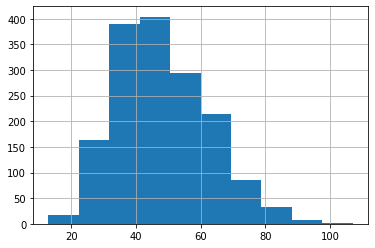

In [ ]:
new_df.groupby('Date')['indicator_ns'].sum().hist()

In [ ]:
new_df.groupby('Date')['indicator_ns'].sum().sort_values()

Date
2020-06-14     13
2020-08-30     15
2020-06-07     18
2021-07-18     19
2020-05-24     19
             ... 
2018-07-09     92
2022-02-04     94
2018-06-01     97
2018-10-15     99
2019-02-27    107
Name: indicator_ns, Length: 1612, dtype: int64

In [ ]:
new_df.columns = [re.sub(' ', '_', x.lower()) for x in new_df.columns]
        
new_df[['date', 'time', 
        'year', 'month', 'day', 
        'weekday', 'hour',
        'line_cleaned', 'station_cleaned', 
        'code', 'desc', 'min_delay', 
        'indicator_ns', 'indicator_station']].to_csv('ttc_subway_delay_data.csv', index = False)

Next, I extracted the year, month, day and hour as separate features, since I'd be interested in studying seasonality of delay patterns.

In [ ]:
#!cp /content/ttc_subway_delay_data.csv /content/drive/MyDrive/subway_eda